In [290]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

## Metricas satelite

In [291]:
sentinel_df = pd.read_csv("data/sentinel_reporte15junio.csv")
sentinel_df.head()

,sum,CVEGEO,quimico,date
0,0.052075,0600100010081,$CO$,2018-11-01
1,0.023302,060010001019A,$CO$,2018-11-01
2,0.008745,0600100010359,$CO$,2018-11-01
3,0.077275,0600100010151,$CO$,2018-11-01
4,0.076924,0600100010166,$CO$,2018-11-01


## Datos suelo y agua

### suelo 

#### Suelo loc

In [292]:
suelo_loc = pd.read_excel("data/sueloagua_informe15junio/Metadatos Suelo.xlsx", 
                      skiprows=6, sheet_name="SUELO")

# Ignore first 30 columns
suelo_loc = suelo_loc.iloc[:, 30:36]
suelo_loc.columns = ["no_muestra", "sitio_muestra", "id_muestra", "fecha_muestra", "x", "y"]
suelo_loc.drop(columns=["no_muestra"], inplace=True)
suelo_loc.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y
0,Tecomán.,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0
1,Tecomán.,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0
2,Tecomán.,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0
3,Tecomán.,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0
4,Tecomán.,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0


In [293]:
## check duplicates on id_muestra
suelo_loc[suelo_loc.duplicated(subset=["id_muestra"], keep=False)]

,sitio_muestra,id_muestra,fecha_muestra,x,y
40,"Nogueras, Colima.",NOG-SS-01,14 de octubre de 2022,632342.0,2137113.0
41,"Nogueras, Colima.",NOG-SS-01,14 de octubre de 2022,632342.0,2137113.0
54,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN


In [294]:
## remove duplicates and null rows
suelo_loc = suelo_loc.drop_duplicates(subset=["id_muestra"], keep="first")
suelo_loc = suelo_loc.dropna(subset=["id_muestra"])

lista = suelo_loc["id_muestra"].apply(lambda x: x if pd.isna(x) else x.split("-"))

# remove "A", "B" and " " from the last element of the list
lista = lista.apply(lambda x: [y.replace("A", "").replace("B", "").replace(" ", "") if i > 1 else y for i, y in enumerate(x)])
lista = lista.apply(lambda x: [y.zfill(2) if i > 1 else y for i, y in enumerate(x)])

# join the list again using "-" as separator and make it upper case
lista = lista.apply(lambda x: "-".join(x).upper())

# replace id_muestra column with the new one
suelo_loc["id_muestra"] = lista

# replace from id_muestra: "V. DE A."" to "VA"
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("V. DE A.", "VA")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("55", "SS")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("MZ", "MZN")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("Q", "QUE")
suelo_loc["id_muestra"] = suelo_loc["id_muestra"].str.replace("CU", "CMO")
suelo_loc["sitio_muestra"] = suelo_loc["sitio_muestra"].str.replace(".", ",")

In [295]:
suelo_loc.sitio_muestra.unique()

rename_sition = {
    "Tecomán.": "Tecomán",
    "Tecomán,": "Tecomán",
    'Quesería, Colima.': "Quesería",
    'Estero Palo Verde, Armeria':"Estero Palo Verde", 
    'Alzada, Cuauhtémoc.': "Alzada",
    'Nogueras, Colima.': "Nogueras", 
    'Canoas, Manzanillo.': "Canoas",
    'Minatitlán.': "Minatitlán",
}

suelo_loc["sitio_muestra"] = suelo_loc["sitio_muestra"].replace(rename_sition)
suelo_loc.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0


#### Suelo metadata

In [296]:
suelo_metadata = pd.read_excel("data/sueloagua_informe15junio/Metadatos Suelo.xlsx", 
                      skiprows=1, sheet_name="SUELO")

# Ignore first 30 columns
suelo_metadata = suelo_metadata.iloc[:, 38:]

## keep first 5 rows
suelo_metadata = suelo_metadata.iloc[:5, :]

## rotate table
suelo_metadata = suelo_metadata.T

## set first row as header
suelo_metadata.columns = suelo_metadata.iloc[0]

## remove second row
suelo_metadata = suelo_metadata.iloc[2:, :]

suelo_metadata

Elemento,Unidades,L.D.D.,Uso agrícola/residencial (mg/kg),Uso industrial (mg/kg),source
V,ppm,0.000018,550,7200,NOM-147-SEMARNAT/SSA1-2004.- Concentraciones d...
Sb,ppm,0.000004,20,40,"Canadian Environmental Quality Guidelines, 2007"
Mn,ppm,0.00001,330,330,https://www.atsdr.cdc.gov/toxprofiles/tp151-c6...
Fe,ppm,0.000479,220,1200,"Goos, R,J. and B.E. Johnson. 2000. Agron. J. 9..."
Co,ppm,0.000002,40,300,"Canadian Environmental Quality Guidelines, 2007"
Ni,ppm,0.000014,50,20000,NOM-147-SEMARNAT/SSA1-2004.- Concentraciones d...
Cu,ppm,0.000035,63,91,"Canadian Environmental Quality Guidelines, 2007"
Zn,ppm,0.000239,200,360,"Canadian Environmental Quality Guidelines, 2008"
Ag,ppm,0.000001,20,40,"Canadian Environmental Quality Guidelines, 2006"
Mo,ppm,0.000016,10,40,"Canadian Environmental Quality Guidelines, 2007"


#### Suelo data

In [297]:
suelo_data = pd.read_excel("data/sueloagua_informe15junio/Metadatos Suelo.xlsx", 
                      skiprows=1, sheet_name="SUELO")

## Ignore first 30 columns
suelo_data = suelo_data.iloc[:, 37:]

## Rename second column to "clave_analisis"
suelo_data.rename(columns={
    "Unnamed: 39": "clave_analisis",
    "Unnamed: 37": "id_muestra"
    }, inplace=True)

## remove first 5 rows
suelo_data = suelo_data.iloc[5:, :]

## remove last 2 rows
suelo_data = suelo_data.iloc[:-2, :]

## remove row with "Co-Su-41 dup" in "clave_analisis" column
suelo_data = suelo_data[suelo_data["clave_analisis"] != 'Co-Su-41 dup ']

## remove empty string from "clave_analisis" column
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.strip()

## make id_muestra column to upper case
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.upper()

## remove "<" from suelo_data columns
suelo_data = suelo_data.replace("<4.74127699566344E-07", "4.74127699566344E-07")

## drop Elemento and clave_analisis columns
suelo_data = suelo_data.drop(columns=["Elemento", "clave_analisis"])

## make type of "clave_analisis" column to string and rest of columns to float
suelo_data["id_muestra"] = suelo_data["id_muestra"].astype(str)
cols = suelo_data.columns.drop("id_muestra")

suelo_data[cols] = suelo_data[cols].astype(float)

## remove "<" from suelo_data columns
suelo_data.columns = suelo_data.columns.str.replace("<", "")

lista = suelo_data["id_muestra"].apply(lambda x: x if pd.isna(x) else x.split("-"))

# remove "A", "B" and " " from the last element of the list
lista = lista.apply(lambda x: [y.replace("A", "").replace("B", "").replace(" ", "") if i > 1 else y for i, y in enumerate(x)])
lista = lista.apply(lambda x: [y.zfill(2) if i > 1 else y for i, y in enumerate(x)])

# join the list again using "-" as separator and make it upper case
lista = lista.apply(lambda x: "-".join(x).upper())

# replace id_muestra column with the new one
suelo_data["id_muestra"] = lista

# replace from id_muestra: "V. DE A."" to "VA"
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("V. DE A.", "VA")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("55", "SS")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("MZ-", "MZN-")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("Q", "QUE")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("CU", "CMO")
suelo_data["id_muestra"] = suelo_data["id_muestra"].str.replace("N06", "NOG")

suelo_data.head()

,id_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
5,TEC-SS-01,52.119857,83.060767,356.421452,20380.124669,6.795681,31.372127,27.613830,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
6,TEC-SS-02,159.152316,276.315419,1005.076752,50577.530073,25.365117,89.874603,20.370812,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
7,TEC-SS-03,106.107911,126.982028,793.213865,37072.895524,16.139127,42.925982,17.016066,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
8,TEC-SS-04,102.633385,112.383905,559.905098,14572.771029,15.059621,41.513285,20.244953,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
9,TEC-SS-05,127.852641,156.285914,885.251725,19517.950289,20.335008,55.237631,21.196320,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [298]:
suelo_data.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [299]:
suelo_loc.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [300]:
# check is id_muestra from suelo_data is in suelo_loc
suelo_data[~suelo_data.id_muestra.isin(suelo_loc.id_muestra)]

,id_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb


#### Resume

In [301]:
suelo_data.head()

,id_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
5,TEC-SS-01,52.119857,83.060767,356.421452,20380.124669,6.795681,31.372127,27.613830,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
6,TEC-SS-02,159.152316,276.315419,1005.076752,50577.530073,25.365117,89.874603,20.370812,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
7,TEC-SS-03,106.107911,126.982028,793.213865,37072.895524,16.139127,42.925982,17.016066,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
8,TEC-SS-04,102.633385,112.383905,559.905098,14572.771029,15.059621,41.513285,20.244953,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
9,TEC-SS-05,127.852641,156.285914,885.251725,19517.950289,20.335008,55.237631,21.196320,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [302]:
suelo_loc.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0


In [303]:
suelo_metadata.head()

Elemento,Unidades,L.D.D.,Uso agrícola/residencial (mg/kg),Uso industrial (mg/kg),source
V,ppm,0.000018,550,7200,NOM-147-SEMARNAT/SSA1-2004.- Concentraciones d...
Sb,ppm,0.000004,20,40,"Canadian Environmental Quality Guidelines, 2007"
Mn,ppm,0.00001,330,330,https://www.atsdr.cdc.gov/toxprofiles/tp151-c6...
Fe,ppm,0.000479,220,1200,"Goos, R,J. and B.E. Johnson. 2000. Agron. J. 9..."
Co,ppm,0.000002,40,300,"Canadian Environmental Quality Guidelines, 2007"


### Agua

In [304]:
agua = pd.read_excel("data/sueloagua_informe15junio/Metadatos.xlsx")

cols_agua = ['Clave', 'Nombre', 'x', 'y', 'Municipio','Uso de agua', 'Fecha de muestreo', 'T°', 'O.D. (%)',
       'O.D. (mg/l)', 'CE (µS/cm)', 'pH', 'ORP (E campo en mV)',
       'Resistividad', 'Solidos disueltos', 'PSU', 'Olor']

agua = agua[cols_agua]
agua.head()

,Clave,Nombre,x,y,Municipio,Uso de agua,Fecha de muestreo,T°,O.D. (%),O.D. (mg/l),CE (µS/cm),pH,ORP (E campo en mV),Resistividad,Solidos disueltos,PSU,Olor
0,ALZ-Ag-01,NaN,654720,21300840,Cuauhtémoc,Potable,2022-10-14,NaN,73.8,8.10,272.00,7.11,346.8,NaN,NaN,NaN,No
1,ALZ-Ag-02,NaN,654578,2130254,Cuauhtémoc,Potable,2022-10-14,NaN,51.4,4.64,283.00,7.02,341.2,NaN,NaN,NaN,No
2,CUAU-AG-M1,Torrecilllas,646560,2139869,Cuauhtémoc,Potable,2022-10-10,25.58,39.7,2.82,210.00,7.47,136.5,0.10,NaN,NaN,No
3,CUAU-AG-M2,La cruz,646619,2138952,Cuauhtémoc,Potable,2022-10-10,24.00,115.7,8.89,199.00,7.71,223.2,0.09,NaN,NaN,No
4,COL-AG-M3+,Lo de Villa,629608,2127304,Colima,Potable,2022-10-11,29.60,20.8,1.51,3.84,7.69,71.0,NaN,192.0,0.18,No


In [305]:
agua.columns

Index(['Clave', 'Nombre', 'x', 'y', 'Municipio', 'Uso de agua',
       'Fecha de muestreo', 'T°', 'O.D. (%)', 'O.D. (mg/l)', 'CE (µS/cm)',
       'pH', 'ORP (E campo en mV)', 'Resistividad', 'Solidos disueltos', 'PSU',
       'Olor'],
      dtype='object')

# Datos geo a GPKG

In [306]:
suelo_loc

,sitio_muestra,id_muestra,fecha_muestra,x,y
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0
5,Tecomán,TEC-SS-07,13 de octubre de 2022,620967.0,2087421.0
6,Tecomán,TEC-SS-08,13 de octubre de 2022,622735.0,2086354.0
7,Tecomán,TEC-SS-09,13 de octubre de 2022,618120.0,2100505.0
8,Tecomán,TEC-SS-10,13 de octubre de 2022,618058.0,2100904.0
9,Tecomán,TEC-SS-11,13 de octubre de 2022,608481.0,2094314.0


In [307]:
suelo_loc.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [308]:
suelo_data.id_muestra.unique()

array(['TEC-SS-01', 'TEC-SS-02', 'TEC-SS-03', 'TEC-SS-04', 'TEC-SS-05',
       'TEC-SS-07', 'TEC-SS-08', 'TEC-SS-09', 'TEC-SS-10', 'TEC-SS-11',
       'QUE-SS-01', 'QUE-SS-02', 'QUE-SS-03', 'QUE-SS-04', 'QUE-SS-05',
       'QUE-SS-06', 'MZN-SS-01', 'MZN-SS-04', 'MZN-SS-09', 'MZN-SS-11',
       'MZN-SS-16', 'MZN-SS-17', 'COL-SS-01', 'COL-SS-03', 'COL-SS-05',
       'COL-SS-08', 'COL-SS-10', 'COL-SS-11', 'COL-SS-12', 'CMO-SS-01',
       'CMO-SS-02', 'CMO-SS-05', 'CMO-SS-06', 'EPV-SS-01', 'EPV-SS-05',
       'VA-SS-06', 'VA-SS-07', 'VA-SS-09', 'ALZ-SS-01', 'ALZ-SS-02',
       'NOG-SS-01', 'CAN-SS-01', 'VA-SS-01', 'MIN-SS-02', 'MIN-SS-03',
       'MIN-SS-05', 'MIN-SS-06', 'MZN-SS-06', 'MZN-SS-10', 'MZN-SS-14',
       'MZN-SS-15', 'MZN-SS-18'], dtype=object)

In [309]:
suelo_geo = suelo_loc[["sitio_muestra",'id_muestra','x', 'y']]
suelo_geo = suelo_loc.merge(suelo_data, on="id_muestra")
suelo_geo.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y,V,Sb,Mn,Fe,Co,...,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0,52.119857,83.060767,356.421452,20380.124669,6.795681,...,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0,159.152316,276.315419,1005.076752,50577.530073,25.365117,...,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0,106.107911,126.982028,793.213865,37072.895524,16.139127,...,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0,102.633385,112.383905,559.905098,14572.771029,15.059621,...,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0,127.852641,156.285914,885.251725,19517.950289,20.335008,...,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [310]:
suelo_geo.head()

,sitio_muestra,id_muestra,fecha_muestra,x,y,V,Sb,Mn,Fe,Co,...,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb
0,Tecomán,TEC-SS-01,13 de octubre de 2022,618792.0,2099659.0,52.119857,83.060767,356.421452,20380.124669,6.795681,...,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174
1,Tecomán,TEC-SS-02,13 de octubre de 2022,616997.0,2093272.0,159.152316,276.315419,1005.076752,50577.530073,25.365117,...,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971
2,Tecomán,TEC-SS-03,13 de octubre de 2022,619193.0,2093032.0,106.107911,126.982028,793.213865,37072.895524,16.139127,...,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398
3,Tecomán,TEC-SS-04,13 de octubre de 2022,619103.0,2091339.0,102.633385,112.383905,559.905098,14572.771029,15.059621,...,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546
4,Tecomán,TEC-SS-05,13 de octubre de 2022,616897.0,2089151.0,127.852641,156.285914,885.251725,19517.950289,20.335008,...,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604


In [311]:
# make suelo_geo from wide to long
suelo_geo_melted = suelo_geo.drop(columns=["sitio_muestra","fecha_muestra","x","y"]).melt(id_vars=["id_muestra"],
                            var_name="parametro",
                
                            value_name="valor")
suelo_geo_melted

,id_muestra,parametro,valor
0,TEC-SS-01,V,52.119857
1,TEC-SS-02,V,159.152316
2,TEC-SS-03,V,106.107911
3,TEC-SS-04,V,102.633385
4,TEC-SS-05,V,127.852641
...,...,...,...
930,MZN-SS-06,Pb,8.241509
931,MZN-SS-10,Pb,1253.844949
932,MZN-SS-14,Pb,5.933980
933,MZN-SS-15,Pb,145.991634


<Axes: xlabel='parametro', ylabel='valor'>

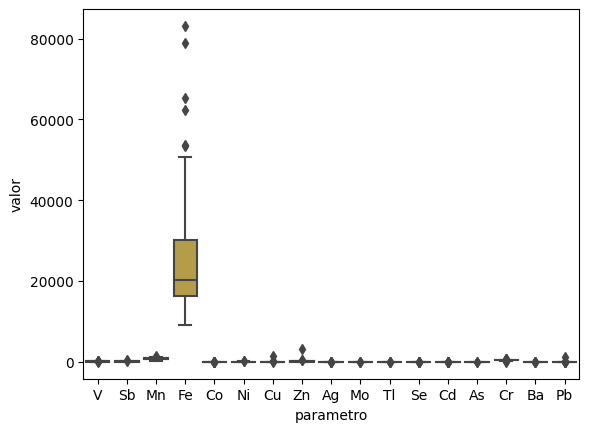

In [312]:
sns.boxplot(data=suelo_geo_melted, x="parametro", y="valor")


Eliminacmos "x", "y","fecha_muestra","id_muestra" ya que la interpolación solo requiere los valores, geometry y el sitio de muestra para interpolar sobre cada sitio de muestreo.

In [313]:


## replace 6614368.0 from x
suelo_geo.loc[43, "x"] = 661436

suelo_geo = gpd.GeoDataFrame(suelo_geo, geometry=gpd.points_from_xy(suelo_geo.x, suelo_geo.y))

## reproject to epsg 103796
suelo_geo = suelo_geo.set_crs(epsg=32213)

suelo_geo = suelo_geo.drop(columns=["x", "y","fecha_muestra","id_muestra"])

suelo_geo.head()

,sitio_muestra,V,Sb,Mn,Fe,Co,Ni,Cu,Zn,Ag,Mo,Tl,Se,Cd,As,Cr,Ba,Pb,geometry
0,Tecomán,52.119857,83.060767,356.421452,20380.124669,6.795681,31.372127,27.613830,116.660981,3.505667,10.439958,1.663528,0.154331,0.205199,7.688118,103.556247,0.365054,3.157174,POINT (618792.000 2099659.000)
1,Tecomán,159.152316,276.315419,1005.076752,50577.530073,25.365117,89.874603,20.370812,157.164260,1.761662,19.372821,1.302758,0.158862,0.128732,5.072610,418.263909,0.041882,2.725971,POINT (616997.000 2093272.000)
2,Tecomán,106.107911,126.982028,793.213865,37072.895524,16.139127,42.925982,17.016066,98.790427,2.980619,28.595521,1.563072,0.177559,0.118065,3.775511,347.903568,0.157877,4.806398,POINT (619193.000 2093032.000)
3,Tecomán,102.633385,112.383905,559.905098,14572.771029,15.059621,41.513285,20.244953,93.135269,1.981310,19.512809,1.709195,0.200527,0.086884,4.441790,356.410165,0.049959,6.400546,POINT (619103.000 2091339.000)
4,Tecomán,127.852641,156.285914,885.251725,19517.950289,20.335008,55.237631,21.196320,92.030821,1.893947,25.393099,1.734721,0.163535,0.085448,4.528717,475.381483,0.052228,3.289604,POINT (616897.000 2089151.000)


In [107]:
## generate a value column with random values between 0 and 100
suelo_geo["value"] = np.random.randint(0, 100, suelo_geo.shape[0])

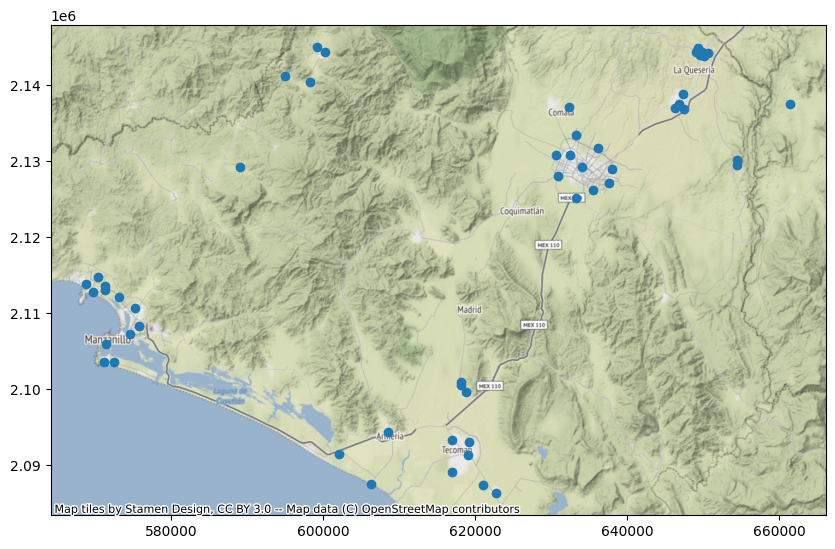

In [106]:
## show map
ax = suelo_geo.plot(figsize=(10, 10))

## set xlim and ylim to ax
xlim = suelo_geo.total_bounds[0::2]
#ax.set_xlim(660000, 670000)

minx, miny, maxx, maxy = suelo_geo.total_bounds
#ax.set_xlim(minx*0.5, maxx*1.5)
#ax.set_ylim(miny*0.8, maxy*1.2)


cx.add_basemap(ax, crs=suelo_geo.crs.to_string())

In [ ]:
def interpolate_gdf(gdf, value, output, method = "cubic"):
    points = np.array([gdf.geometry.x, gdf.geometry.y]).T
    values = gdf[value]  # Reemplaza 'value' con el nombre de tu columna de valores

    # Definir la cuadrícula de interpolación
    minx, miny, maxx, maxy = gdf.total_bounds
    grid_x, grid_y = np.mgrid[minx:maxx:1000j, miny:maxy:1000j]  # Ajusta el tamaño de la cuadrícula según sea necesario

    # Interpolar los datos
    grid_z = griddata(points, values, (grid_x, grid_y), method=method)

    # Crear una transformación para la cuadrícula
    transform = from_origin(minx, maxy, (maxx-minx)/1000, (maxy-miny)/1000)  # Ajusta el tamaño de la cuadrícula según sea necesario

    # Guardar los datos interpolados como un GeoTIFF
    with rasterio.open(output, 'w', driver='GTiff', height=grid_z.shape[0],
                    width=grid_z.shape[1], count=1, dtype=str(grid_z.dtype),
                    crs=gdf.crs, transform=transform) as dst:
        dst.write(grid_z[::-1], 1)
    
    ## load interpolated raster 
    interpolated = rasterio.open(output)

    return interpolated